# Classifying Blood Smears with a Convolutional Neural Network

This notebook provides you with a complete code example that loads the malaria dataset, trains a convolutional neural network with dense top to classify the images of cell with and without malaria, analyzes where the trained network fails, and shows the network activations and heatmaps.

## Loading the Malaria Dataset

This dataset was originally published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. _Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images._ PeerJ 6, e4568, 2018.

It is available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip.


In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists("blood_smears_dataset"):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

### Transforming the Images and Their Ground Thruth

Define a transformation to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1) ...

In [2]:
from torchvision.transforms import Compose, Resize, ToTensor

image_trans = Compose([Resize((28, 28)), ToTensor()])

... define a transformation to make the target label equal to 0 for the uninfected cells and to 1 for the parasitized ones, converting it into a floating-point PyTorch tensor and adding a new dimension for batch processing ...

In [3]:
import torch

def label_trans(label):
    """Transform label."""
    return torch.tensor(1 - label).float().unsqueeze(-1)

... and define a dataset that also makes these transformations.

In [4]:
from torchvision.datasets import ImageFolder

base_dir = os.path.join(dataset_path, "cell_images")
dataset = ImageFolder(base_dir, transform=image_trans, 
                      target_transform=label_trans)

### Visualizing the Blood Smears

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_blood_smears(dataset, parasitized):
    """Plot blood smears."""
    fig, axs = plt.subplots(3, 6, figsize=(16, 8))
    for ax in axs.ravel():
        image, label = dataset[np.random.randint(0, len(dataset))]
        if isinstance(image, torch.Tensor):
            image, label = image.numpy().transpose(1, 2, 0), label.numpy()
        ax.imshow(image)
        ax.set_title(f"Parasitized ({label})" if label == parasitized 
                     else f"Uninfected ({label})", fontsize=20)
    plt.tight_layout()
    plt.show()

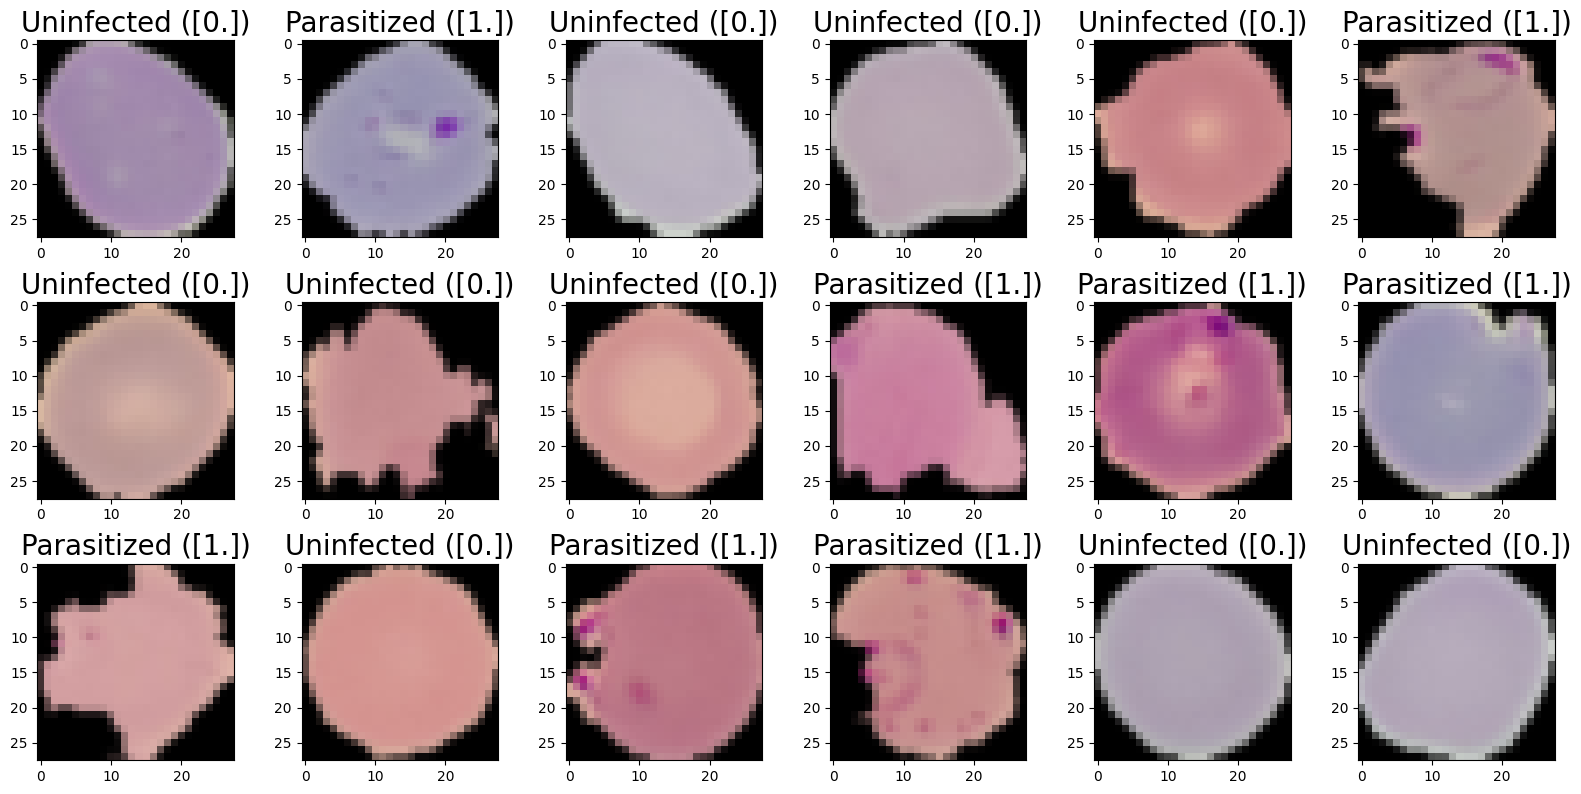

In [14]:
plot_blood_smears(dataset, parasitized=1)

### Splitting the Dataset and Defining the Data Loaders

Split the dataset, composed by ca. 27,000 cell images, into train (80%) and test (20%) sets.

In [15]:
train, test = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=256, shuffle=False)

## Classifying the Blood Smears with Dense Neural Networks

Implement a dense neural network ...

In [16]:
import deeplay as dl

dnn = dl.MultiLayerPerceptron(in_features=28 * 28 * 3,
                              hidden_features=[128, 128], out_features=1, 
                              out_activation=torch.nn.Sigmoid)

print(dnn)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Layer[Linear](in_features=2352, out_features=128, bias=True)
      (activation): Layer[ReLU]()
    )
    (1): LinearBlock(
      (layer): Layer[Linear](in_features=128, out_features=128, bias=True)
      (activation): Layer[ReLU]()
    )
    (2): LinearBlock(
      (layer): Layer[Linear](in_features=128, out_features=1, bias=True)
      (activation): Layer[Sigmoid]()
    )
  )
)


... and compile it.

In [17]:
dnn_classifier = dl.BinaryClassifier(model=dnn, 
                                     optimizer=dl.RMSprop(lr=0.001)).create()

print(dnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (activation): ReLU()
      )
      (1): LinearBlock(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
      )
      (2): LinearBlock(
        (layer): Linear(in_features=128, out_features=1, bias=True)
        (activation): Sigmoid()
      )
    )
  )
  (optimizer): RMSprop[RMSprop](lr=0.001)
)


The default loss of `dl.BinaryClassifier` is a binary cross-entropy loss.

### Training the Dense Neural Network

In [18]:
dnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
dnn_trainer.fit(dnn_classifier, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: /Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN/ec03_A_blood_smears/lightning_logs


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type                 ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ BCELoss              │      0 │
│ 1 │ train_metrics │ MetricCollection     │      0 │
│ 2 │ val_metrics   │ MetricCollection     │      0 │
│ 3 │ test_metrics  │ MetricCollection     │      0 │
│ 4 │ model         │ MultiLayerPerceptron │  317 K │
│ 5 │ optimizer     │ RMSprop              │      0 │
└───┴───────────────┴──────────────────────┴────────┘

Trainable params: 317 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 317 K                                                                                                
Total estimated model params size (MB): 1

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


### Testing the Dense Neural Network

In [19]:
dnn_trainer.test(dnn_classifier, test_loader)

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testBinaryAccuracy_epoch  │    0.6438032984733582     │
│      test_loss_epoch      │    0.6230658292770386     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.6230658292770386,
  'testBinaryAccuracy_epoch': 0.6438032984733582}]

### Plotting the ROC Curve

In [20]:
import torchmetrics as tm

def plot_roc(classifier, loader):
    """Plot ROC curve."""
    roc = tm.ROC(task="binary")
    for image, label in loader:
        roc.update(classifier(image), label.long())

    fig, ax = roc.plot(score=True)
    ax.grid(False); ax.axis("square"); ax.legend(loc="center right")
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    plt.show()

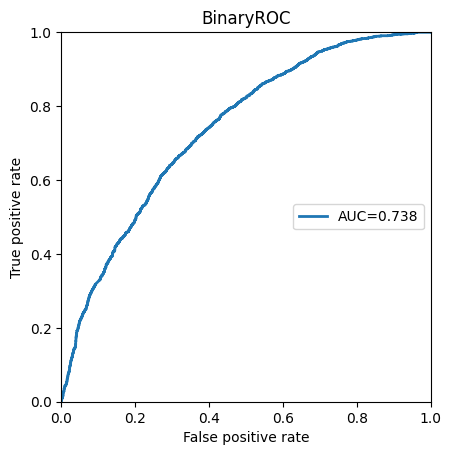

In [21]:
plot_roc(dnn_classifier, test_loader)

## Classifying the Blood Smears with Convolutional Neural Networks

Implement a convolutional neural network with a dense top ...

In [22]:
conv_base = dl.ConvolutionalNeuralNetwork(in_channels=3,
    hidden_channels=[16, 16, 32], out_channels=32)
conv_base.blocks[2].pool.configure(torch.nn.MaxPool2d, kernel_size=2)

connector = dl.Layer(torch.nn.AdaptiveAvgPool2d, output_size=1)

dense_top = dl.MultiLayerPerceptron(in_features=32, hidden_features=[],
    out_features=1, out_activation=torch.nn.Sigmoid)

cnn = dl.Sequential(conv_base, connector, dense_top)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (1): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (2): Conv2dBlock(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
      )
      (3): Conv2dBlock(
        (layer): Layer[Conv2d](in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[Identity]()
      )
    )
  )
  (1): Layer[AdaptiveAvgPool2d](output_size=1)
  (2): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=1, bias=Tr

... and compile it.

In [23]:
cnn_classifier = dl.BinaryClassifier(model=cnn, 
                                     optimizer=dl.RMSprop(lr=0.001)).create()

print(cnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): Conv2dBlock(
          (layer): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (1): Conv2dBlock(
          (layer): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (2): Conv2dBlock(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (layer): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
        )
        (3): Conv2dBlock(
          (la

### Training the Convolutional Neural Network

In [24]:
cnn_trainer = dl.Trainer(max_epochs=5, accelerator="auto")
cnn_trainer.fit(cnn_classifier, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ BCELoss          │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ Sequential       │ 16.7 K │
│ 5 │ optimizer     │ RMSprop          │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 16.7 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.7 K                                                                                               
Total estimated model params size (MB): 0

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


### Testing the Convolutional Neural Network

In [25]:
cnn_trainer.test(cnn_classifier, test_loader)

Output()

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ testBinaryAccuracy_epoch  │     0.945200502872467     │
│      test_loss_epoch      │    0.1538468450307846     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.1538468450307846,
  'testBinaryAccuracy_epoch': 0.945200502872467}]

### Plotting the ROC Curve

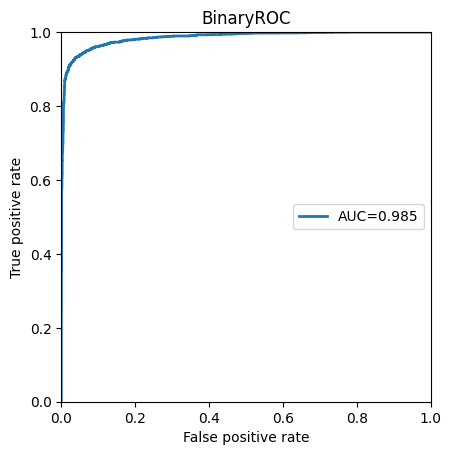

In [26]:
plot_roc(cnn_classifier, test_loader)

### Checking the Values of the Filters

The following code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[15]`). 

In [27]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[15]

print(filter)

tensor([[[ 0.0819, -0.0956,  0.0951],
         [ 0.1191, -0.2844,  0.0850],
         [ 0.0815,  0.0015, -0.1101]],

        [[-0.0102,  0.0954,  0.0008],
         [ 0.0609, -0.2371, -0.0830],
         [-0.0128,  0.1423,  0.1383]],

        [[-0.0880, -0.0185,  0.2121],
         [-0.1960, -0.0928, -0.0507],
         [-0.0782, -0.2222, -0.1306]]], grad_fn=<SelectBackward0>)


### Visualizing the Activations of the Convolutional Layers

Pick the image of an infected smear to then check the activations it produces on the last convolutional layer ...

In [32]:
from PIL import Image

im_ind = 0
image_hr = Image.open(dataset.samples[im_ind][0])
image = image_trans(image_hr)

In [33]:
print(label_trans(dataset.targets[im_ind]))

tensor([1.])


... define a function to visualize the activations ...

In [37]:
def plot_activations(activations, cols=8):
    """Visualize activations."""
    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis("off")
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i, fontsize=16)
    plt.show()

... add a hook to access the activations in the forward pass ...


Activations size: torch.Size([1, 16, 28, 28])


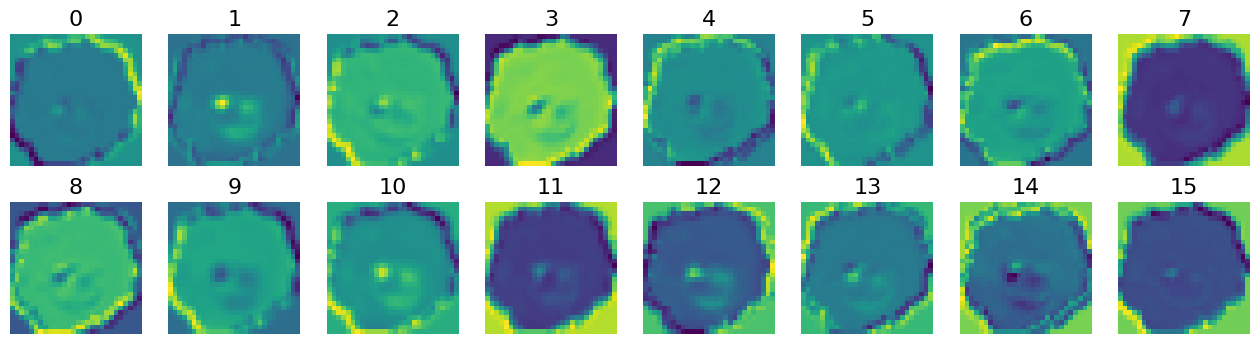

Activations size: torch.Size([1, 16, 28, 28])


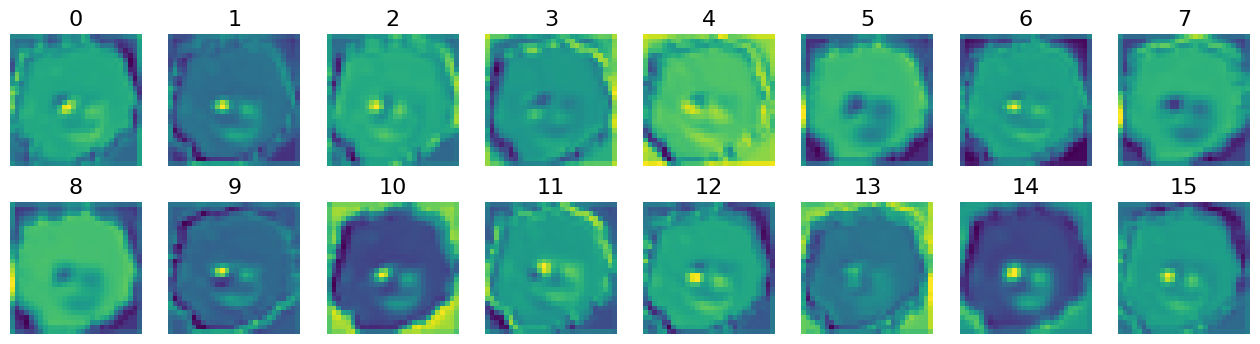

Activations size: torch.Size([1, 16, 28, 28])


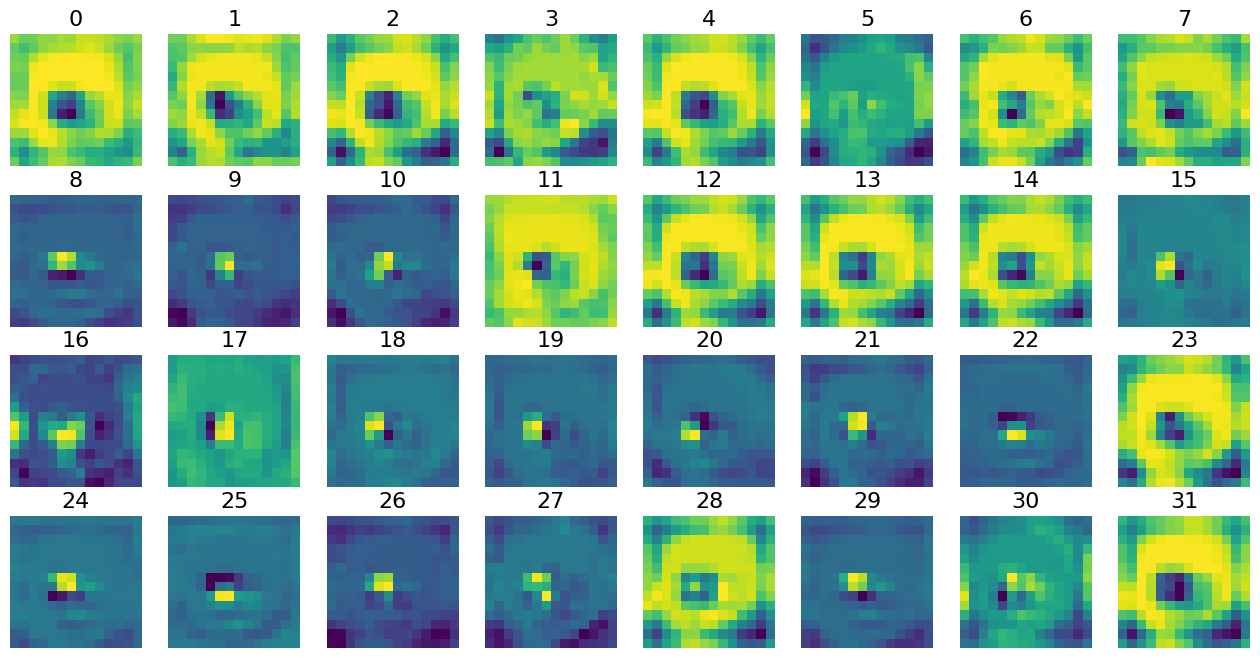

Activations size: torch.Size([1, 16, 28, 28])


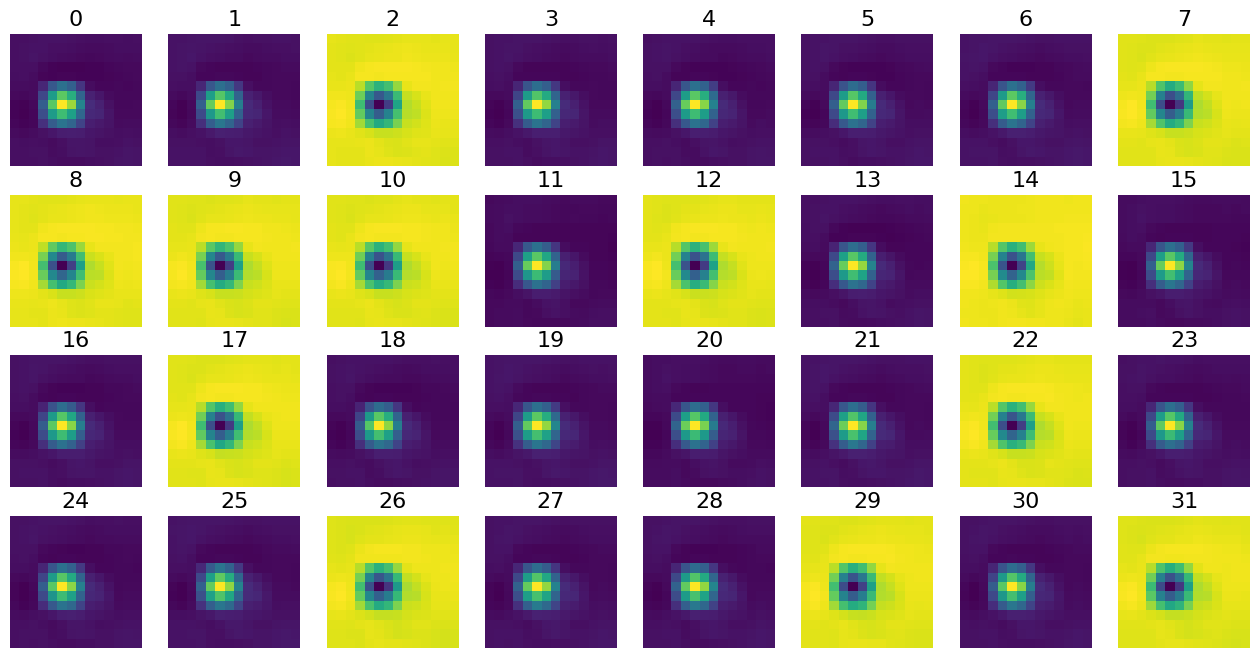

In [40]:
def hook_func(layer, input, output):
    """Hook for activations."""
    activations = output.detach().clone()
    plot_activations(activations[0])

for block in cnn_classifier.model[0].blocks:
    layer = block.layer
    handle_hook = layer.register_forward_hook(hook_func)

    try:
        pred = cnn_classifier.model(image.unsqueeze(0))
    except Exception as e:
        print(f"An error occurred during model prediction: {e}")
    finally:
        handle_hook.remove()

### Visualizing the Heatmaps

Use hooks to keep tracks also of the gradients in the backward pass ...

In [41]:
hookdata = {}

def fwd_hook_func(layer, input, output):
    """Forward hook function."""
    hookdata["activations"] = output.detach().clone()

def bwd_hook_func(layer, grad_input, grad_output):
    """Backward hook function."""
    hookdata["gradients"] = grad_output[0].detach().clone()

layer = cnn_classifier.model[0].blocks[3].layer
handle_fwd_hook = layer.register_forward_hook(fwd_hook_func)
handle_bwd_hook = layer.register_full_backward_hook(bwd_hook_func)

try:
    pred = cnn_classifier.model(image.unsqueeze(0))
    pred.backward()
except Exception as e:
    print(f"An error occurred during model prediction: {e}")
finally:
    handle_fwd_hook.remove()
    handle_bwd_hook.remove()

Activations size: torch.Size([1, 16, 28, 28])


... calculate the heatmap combining activations and gradients ...

In [42]:
from torch.nn.functional import relu

activations = hookdata["activations"][0]
gradients = hookdata["gradients"][0]

pooled_gradients = gradients.mean(dim=[1, 2], keepdim=True)
heatmap = relu((pooled_gradients * activations).sum(0)).detach().numpy()

... and plot the heatmap.

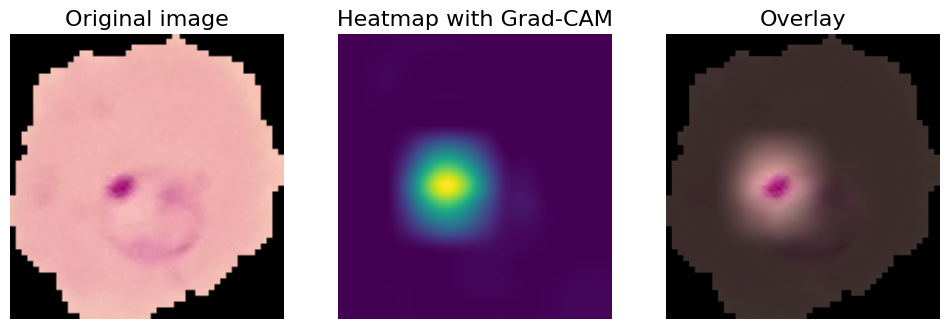

In [50]:
import skimage
from numpy import array

image = skimage.exposure.rescale_intensity(array(image_hr), out_range=(0, 1))
heatmap = skimage.transform.resize(heatmap, image.shape, order=2)
heatmap = skimage.exposure.rescale_intensity(heatmap, out_range=(0.25, 1))

plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.imshow(image, interpolation="bilinear")
plt.title("Original image", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap.mean(axis=-1), interpolation="bilinear")
plt.title("Heatmap with Grad-CAM", fontsize=16)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(image * heatmap)
plt.title("Overlay", fontsize=16)
plt.axis("off")

plt.show()